# Image Classification
***Remark :*** This notebook contains two part
1. How to Train
2. Direct Deploy model without any need of training model

### More Details  

* In this notebook we are going to fine tune a pre trained model using `PyTorch`
  - Model used : [EffecientNet B2](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights)
  - Dataset used : [Food101](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
* Learn new way to get the model from `Torchvision`

***Remark -*** If you are using google colab change run time
* Click on Runtime in top right side of the screen
* Click on change Runtime type
* Change Hardware accelerator to GPU and click on Save

## Importing Librarys
Pre requriements for run Localy
* [PyTorch](https://pytorch.org/get-started/locally/)
* [Torchinfo](https://pypi.org/project/torchinfo/)

In [ ]:
import os
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm # For Progressing bar in training time
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
try:
  from torchinfo import summary  # for getting a summary of the model
except:
  !pip install torchinfo
  from torchinfo import summary

### Device-agnostic code

In [ ]:
import torch
device= "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# Detail if GPU is Present
!nvidia-smi

Fri Jul 21 14:48:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Model ( weights + transforms )


In [ ]:
import torchvision
# geting the weights for EfficientNet B2 and then get the transforms
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # ".DEFAULT" = best available weights
# Transforms used in EfficientNet B2
transform=weights.transforms()
# Model
model = torchvision.models.efficientnet_b2(weights=weights).to(device)
# print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 61.2MB/s]


## Dataset + DataLoader (4.7GB)  


In [ ]:
import os
from pathlib import Path
from torch.utils.data import DataLoader
# making dir for data
data_path=Path("data")
data_path.mkdir(parents=True,exist_ok=True)

# Dataset
train_data=torchvision.datasets.Food101(root=data_path,
                                       split="train",
                                       transform=transform,
                                       download=True)
test_data=torchvision.datasets.Food101(root=data_path,
                                      split="test",
                                      transform=transform,
                                      download=True)
# DataLoaders
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=64,
                            shuffle=True,
                            num_workers=os.cpu_count())
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=64,
                           shuffle=False,
                           num_workers=os.cpu_count())
# print(train_dataloader,test_dataloader,len(train_dataloader),len(test_dataloader))

100%|██████████| 4996278331/4996278331 [05:49<00:00, 14278549.95it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
# Creating class_names list and Class_to_idx dict
class_names=train_data.classes
class_to_idx=train_data.class_to_idx
# class_names,class_to_idx

### train_step, test_step, train function to train model

In [ ]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
  #setting the model to train mode
  total_loss,total_acc=0,0
  for i,(X,y) in enumerate(train_dataloader):
    # to device
    X,y=X.to(device),y.to(device)
    # forward pass
    y_logits=model(X)
    # loss calculate
    loss=loss_fn(y_logits,y)
    # zero the optimizer
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()
    total_acc+=(torch.argmax(y_logits,dim=1)==y).sum()/len(y)
    total_loss+=loss
  total_loss/=len(train_dataloader)
  total_acc=total_acc/len(train_dataloader)
  return total_loss,total_acc

def test_step(model,
            test_dataloader,
            loss_fn,
            device):
  """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
  # eval model
  with torch.inference_mode():
    test_loss,test_acc=0,0
    for i,(X,y) in enumerate(test_dataloader):
      X,y=X.to(device),y.to(device)
      y_logits=model(X)
      test_acc+=(torch.argmax(y_logits,dim=1)==y).sum()/len(y)
      test_loss+=loss_fn(y_logits,y)
    test_loss/=len(test_dataloader)
    test_acc=test_acc/len(test_dataloader)
  return test_loss,test_acc

def train(model,
          train_dataloader,
          test_dataloader,
          loss_fn,
          optimizer,
          epochs,
          device):
  """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
  status_dict={"train_loss":[],
                "train_acc":[],
                "test_loss":[],
                "test_acc":[]}
  from pathlib import Path
  save_path=Path("models")
  save_path.mkdir(parents=True,exist_ok=True)
  model.to(device)
  for epoch in tqdm(range(epochs)):
    model.train()
    loss_train,acc_train=train_step(model,
               train_dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device)
    status_dict["train_loss"].append(loss_train)
    status_dict["train_acc"].append(acc_train)
    model.eval()
    loss_test,acc_test=test_step(model,
                    test_dataloader,
                    loss_fn,
                    device)
    status_dict["test_loss"].append(loss_test)
    status_dict["test_acc"].append(acc_test)
    print(f"epoch : {epoch+1} | train_loss : {loss_train} | train_acc : {acc_train} | test_loss : {loss_test} | test_acc : {acc_test}")
    model_path=save_path/f"model_effecientnet_b2_weights_{epoch}.pth"
    torch.save(obj=model.state_dict(),f=model_path)
  return status_dict

## Fine Tuning
* ### Feature Extraction
  1. Making all layers ***Requires_grad=False***
  2. Change the Classification layer to suit your requirement
  3. Train Model for some (5-10) epochs
* ### Fine Tuning

  ***Remark :*** In fine tuning we use vary `low learning rate` like - 1e-5

  ***Remark :*** In fine tuning we `don't train normalize layer` like - [batchnorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

  * Half Model trainable
    1. Making upper layer trainable
    2. Train Model for 4-5 epochs
  * Full Model trainable
    1. Making all layer trainable
    2. Train Model for 3-4 epochs

### Feature Extraction

In [ ]:
# Setting all parameters to not-trainable
for params in model.parameters():
  params.requires_grad=False

# Changing Classification layer
model.classifier=nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(in_features=1408,out_features=len(class_names)))
model.classifier

# checking the status of the parameters of models
from torchinfo import summary
""" To find the status of model uncomment below 4 lines"""
print(summary(model,
        input_size=(32,3,288,288),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=18))

# Loss_fn + optimizer + train the model
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
state_dict=train(model,train_dataloader,test_dataloader,loss_fn,optimizer,5,device)
# print(state_dict)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [32, 3, 288, 288]  [32, 101]          --                 Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]  [32, 1408, 9, 9]   --                 False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]  [32, 32, 144, 144] --                 False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]  [32, 32, 144, 144] (864)              False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144] [32, 32, 144, 144] (64)               False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144] [32, 32, 144, 144] --                 --
│    └─Sequential: 2-2                                  [32, 32, 144, 144] [32, 16, 144, 144] --                 False
│    │    └─MBConv: 3-4                      

### Fine Tuning Part 1

In [ ]:
for params in model.features[5:].parameters(): # Making the models upper layer un froze
  params.requires_grad=True

for m in model.modules(): # Making the BatchNorm2d froze
  if isinstance(m, nn.BatchNorm2d):
    m.track_running_stats = False
    m.eval()

# checking the status of the parameters of models
from torchinfo import summary
""" To find the status of model uncomment below 4 lines"""
print(summary(model,
        input_size=(32,3,288,288),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=18))

# Loss_fn + optimizer + train the model
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
state_dict=train(model,train_dataloader,test_dataloader,loss_fn,optimizer,4,device)
# print(state_dict)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [32, 3, 288, 288]  [32, 101]          --                 Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]  [32, 1408, 9, 9]   --                 Partial
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]  [32, 32, 144, 144] --                 False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]  [32, 32, 144, 144] (864)              False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144] [32, 32, 144, 144] (64)               False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144] [32, 32, 144, 144] --                 --
│    └─Sequential: 2-2                                  [32, 32, 144, 144] [32, 16, 144, 144] --                 False
│    │    └─MBConv: 3-4                    

### Fine Tuning Part 2

In [ ]:
for params in model.features.parameters(): # Making the models upper layer un froze
  params.requires_grad=True

for m in model.modules(): # Making the BatchNorm2d froze
  if isinstance(m, nn.BatchNorm2d):
    m.track_running_stats = False
    m.eval()

# checking the status of the parameters of models
from torchinfo import summary
""" To find the status of model uncomment below 4 lines"""
print(summary(model,
        input_size=(32,3,288,288),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=18))

# Loss_fn + optimizer + train the model
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)
state_dict=train(model,train_dataloader,test_dataloader,loss_fn,optimizer,3,device)
# print(state_dict)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [32, 3, 288, 288]  [32, 101]          --                 True
├─Sequential: 1-1                                       [32, 3, 288, 288]  [32, 1408, 9, 9]   --                 True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]  [32, 32, 144, 144] --                 True
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]  [32, 32, 144, 144] 864                True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144] [32, 32, 144, 144] 64                 True
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144] [32, 32, 144, 144] --                 --
│    └─Sequential: 2-2                                  [32, 32, 144, 144] [32, 16, 144, 144] --                 True
│    │    └─MBConv: 3-4                              

### Saving the model
We can save the model using Pytorch or make a pickle file .
Advantage of pickle over Pytorch (saving state_dict ) is that we don't have to instantiate the model . We can get model in just one line of code.

We will be using pickle .

In [ ]:
# Using pytorch
# model_name = "EfficientNet_B2_pytorch.pth"
# torch.save(obj=model.state_dict(),f=model_name)

# using pickle
import pickle
pickle.dump(model,open("pickle.pkl","wb"))

### Some Pridictions

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


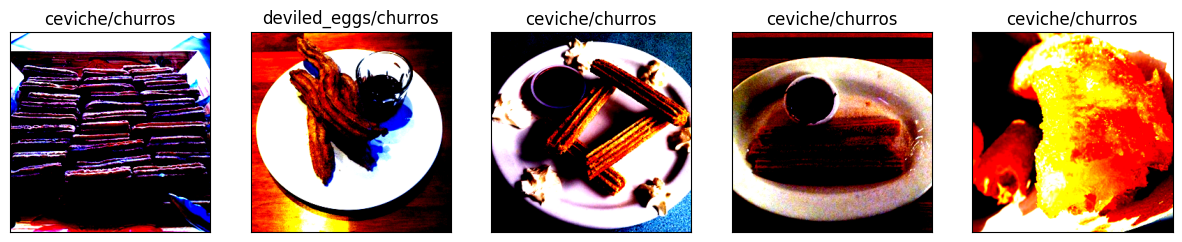

In [ ]:
# Pridict function take input a dataset (test_data) and a int (no. of images)
def predict_k(model,test_data,class_names,k,transform=transform):
  model.eval()
  if k>5:
    k=5
    print(f"the given k value is too much setting it to 5")
  fig,ax=plt.subplots(1,k,figsize=(15,15*k));

  for i in range(k):
    img=transform(test_data[i][0]).unsqueeze(dim=0).to(device)
    # print(img.shape)
    pred=model(img)
    # print(class_names[torch.argmax(pred,dim=1)])
    ax[i].imshow(test_data[i][0].permute(1,2,0));
    ax[i].title.set_text(f"{class_names[torch.argmax(pred,dim=1)]}/{class_names[test_data[i][1]]}"); # set the label
    ax[i].set_xticks([]);
    ax[i].set_yticks([]);
  fig.show();

predict_k(model,test_data,class_names,5)

#### pred_and_plot_image function

In [ ]:
from typing import List, Tuple
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (288, 288),
    transform: torchvision.transforms = None,
    device: torch.device = device):

    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)
    # return img
    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)
    plt.show()

2023-07-21 08:15:37 URL:https://bigoven-res.cloudinary.com/image/upload/t_recipe-1280/maryland-crab-cakes-8.jpg [144743/144743] -> "file.jpg" [1]


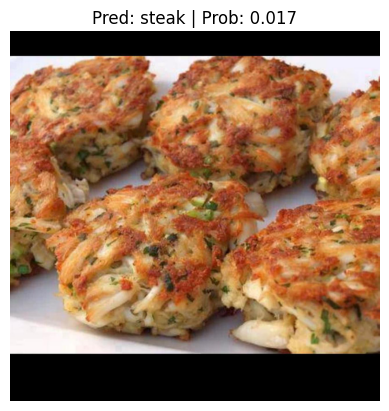

In [ ]:
!wget -nv https://bigoven-res.cloudinary.com/image/upload/t_recipe-1280/maryland-crab-cakes-8.jpg -O "file.jpg"
pred_and_plot_image(model,class_names,"file.jpg")

# If you wants to run directly run below

In [ ]:
# Import
import requests
import torch
import torchvision
from torchvision import transforms
from timeit import default_timer as timer
from PIL import Image
import pickle

# device-egnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
# download the model.pkl file from github and model instantiate
with open("model.pkl","wb") as f:
  request=requests.get("https://github.com/Rajatsingh24/FoodVision/raw/main/model.pkl")
  f.write(request.content)
  print(f"[INFO] model.pkl downloaded.")
# Create the model
model=pickle.load(open("model.pkl","rb"))
model.to(device)
# Transform for prediction
transform=torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

# getting class_names
with open("class_names.txt","wb") as f:
  request=requests.get("https://github.com/Rajatsingh24/FoodVision/raw/main/class_names.txt")
  f.write(request.content)
  print(f"[INFO] class_names.txt downloaded")
# Class_names
with open("class_names.txt","r") as f:
  class_names=[food.strip() for food in f.readlines()]


[INFO] model.pkl downloaded.
[INFO] class_names.txt downloaded


## Gradio demo app
what is [Gradio](https://www.gradio.app/) ?

Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

In [ ]:
# Install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr
print(f"gradio version {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.6 MB/s eta 0:

#### Predict function

In [ ]:
model.to(device)
next(iter(model.parameters())).to(device)
def predict(img):
  model.eval()
  start_time =timer()
  with torch.inference_mode():
    t_img=transform(img).unsqueeze(0).to(device)
    # print(t_img)
    probs=torch.softmax(model(t_img),dim=1).to("cpu")
  end_time=timer()
  label_and_prob={class_names[i] : float(probs[0][i]) for i in range(len(class_names))}
  print(probs)
  return label_and_prob,round(end_time-start_time,4)

!wget -nv https://www.engelvoelkers.com/wp-content/uploads/2014/07/pizza-stock.jpg -O "pizza.jpg"
img=Image.open("pizza.jpg")
_,_=predict(img)

2023-07-21 14:36:34 URL:https://www.engelvoelkers.com/wp-content/uploads/2014/07/pizza-stock.jpg [696280/696280] -> "pizza.jpg" [1]
tensor([[2.0969e-05, 1.0211e-07, 2.0160e-06, 2.1745e-05, 3.3434e-06, 1.4737e-06,
         3.1813e-08, 5.8295e-07, 1.3754e-05, 2.8005e-06, 6.9168e-03, 4.1328e-07,
         1.6799e-04, 1.5109e-06, 4.1941e-05, 4.1024e-06, 9.2364e-07, 1.1133e-04,
         6.6275e-08, 1.0807e-05, 2.5098e-07, 1.2758e-05, 7.9723e-08, 4.6194e-06,
         3.1387e-07, 1.4453e-06, 2.3003e-06, 1.9453e-06, 3.9412e-06, 3.8533e-07,
         1.2688e-06, 5.2939e-06, 5.7715e-07, 2.2295e-09, 6.9096e-07, 7.2741e-04,
         1.5544e-06, 8.1803e-08, 1.1759e-08, 1.7322e-04, 3.2065e-07, 2.2054e-06,
         6.4724e-05, 1.0828e-07, 2.3370e-08, 8.0363e-08, 2.5583e-05, 3.1253e-05,
         4.0325e-07, 1.2869e-04, 4.0000e-04, 4.4949e-09, 3.7240e-07, 3.7758e-06,
         4.5712e-09, 3.0949e-05, 2.2744e-05, 3.9556e-05, 2.1626e-06, 8.7070e-05,
         5.9162e-07, 6.2866e-06, 2.5054e-06, 1.6416e-07, 1

In [ ]:
from pathlib import Path
sample_path=Path("sample")
sample_path.mkdir(parents=True, exist_ok=True)
!wget -nv https://www.engelvoelkers.com/wp-content/uploads/2014/07/pizza-stock.jpg -O "sample/pizza.jpg"
!wget -nv https://wallsdesk.com/wp-content/uploads/2016/10/Beef-Steak-HD-Wallpaper.jpg -O "sample/steake.jpg"
!wget -nv https://blogs.biomedcentral.com/bugbitten/wp-content/uploads/sites/11/2017/05/SUSHI-02.jpg -O "sample/sushi.jpg"

example_list=[["sample/pizza.jpg"],["sample/sushi.jpg"],["sample/steake.jpg"]]
example_list

2023-07-21 14:37:23 URL:https://www.engelvoelkers.com/wp-content/uploads/2014/07/pizza-stock.jpg [696280/696280] -> "sample/pizza.jpg" [1]
2023-07-21 14:37:25 URL:https://wallsdesk.com/wp-content/uploads/2016/10/Beef-Steak-HD-Wallpaper.jpg [7496862/7496862] -> "sample/steake.jpg" [1]
2023-07-21 14:37:27 URL:https://blogs.biomedcentral.com/bugbitten/wp-content/uploads/sites/11/2017/05/SUSHI-02.jpg [2198902/2198902] -> "sample/sushi.jpg" [1]


[['sample/pizza.jpg'], ['sample/sushi.jpg'], ['sample/steake.jpg']]

In [ ]:
# gradio demo api
import gradio as gr

# Create title, description and article strings
title = "Food Vision 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food of 101 different Category."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time(s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description)
                    # article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://21ed88eebdfbd38fe6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## A IFrame for direct using my trained model

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://huggingface.co/spaces/rajatsingh0702/FoodVision", width=1400, height=750)